# Chapter 4 — How to Solve a Nonlinear System

**Based on:** J.C.G. Walker, *Numerical Adventures with Geochemical Cycles*,
Oxford University Press, 1991.

---

## 4.1 Overview

Chapters 2 and 3 dealt with **linear** systems — where the fluxes between
reservoirs are proportional to the reservoir contents. In those cases, the
reverse Euler method leads to a linear system of equations that can be solved
by Gaussian elimination.

But as Walker notes at the end of Chapter 3: *"the more interesting problems
tend to be neither steady state nor linear."*

Most real geochemical systems are **nonlinear**. The most important example
is the ocean carbonate system, where the relationship between dissolved CO₂
and total dissolved inorganic carbon (DIC) is highly nonlinear due to the
**buffer chemistry** of seawater. This nonlinearity is quantified by the
**Revelle (buffer) factor** ≈ 10, meaning that a 10% increase in atmospheric
CO₂ produces only a ~1% increase in oceanic DIC.

Walker's solution: extend the reverse Euler by using **Newton-Raphson
iteration** to solve the nonlinear equations at each time step. This
combines the stability advantages of the implicit method with an iterative
linearisation scheme.

### Chapter structure

1. Why nonlinearity matters: the Revelle factor
2. Newton-Raphson method for root-finding
3. Reverse Euler + Newton-Raphson for nonlinear ODEs
4. Application: CO₂ exchange with a nonlinear ocean

---

## 4.2 Why Nonlinearity Matters: The Ocean Carbonate Buffer

In Chapters 2 and 3, we assumed that the flux of CO₂ from the ocean to the
atmosphere is **constant** (independent of oceanic carbon content). This is
equivalent to assuming the ocean is an infinite reservoir.

In reality, when extra CO₂ dissolves in seawater, it enters the carbonate
equilibrium system:

$$
\text{CO}_2 + \text{H}_2\text{O} \rightleftharpoons \text{H}_2\text{CO}_3
\rightleftharpoons \text{H}^+ + \text{HCO}_3^-
\rightleftharpoons 2\text{H}^+ + \text{CO}_3^{2-}
$$

The dissolved CO₂ (which controls the atmospheric partial pressure) is only
a small fraction (~0.5%) of the total DIC. Most of the carbon is in the form
of bicarbonate (HCO₃⁻, ~90%) and carbonate (CO₃²⁻, ~9.5%).

The **Revelle factor** $R$ quantifies this buffering:

$$
R = \frac{\Delta p\text{CO}_2 / p\text{CO}_2}{\Delta \text{DIC} / \text{DIC}}
\approx 10
$$

This means: to increase oceanic pCO₂ by 10%, you only need to increase
DIC by ~1%. Equivalently, the ocean's ability to absorb additional CO₂
is about **10 times less** than a simple linear model would predict.

### A simplified nonlinear model

Walker introduces a power-law approximation for the ocean pCO₂ response:

$$
p\text{CO}_2^{\text{ocean}} \propto (\text{DIC})^\xi
$$

where $\xi \approx 10$ is the Revelle factor. This captures the essential
nonlinearity: a small change in oceanic carbon produces a large change in
the ocean's CO₂ partial pressure.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve

np.set_printoptions(precision=6, suppress=True)

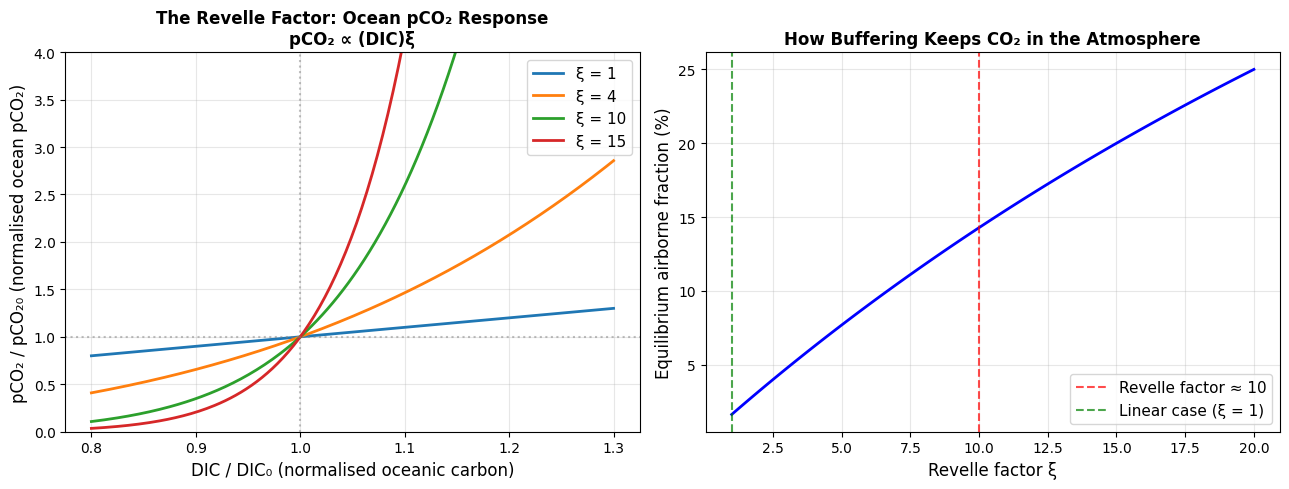

With ξ = 1 (linear): airborne fraction = 1.6%
With ξ = 10 (Revelle): airborne fraction = 14.3%

The nonlinearity keeps ~14% vs ~2% in the atmosphere!


In [24]:
# Illustrate the Revelle factor: how pCO2 depends on DIC

# Normalised: DIC/DIC_0 = c, pCO2/pCO2_0 = c^xi
xi_values = [1, 4, 10, 15]  # Revelle factor
c = np.linspace(0.8, 1.3, 200)  # DIC relative to equilibrium

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

for xi in xi_values:
    pco2 = c**xi
    ax1.plot(c, pco2, linewidth=2, label=f'ξ = {xi}')

ax1.axhline(y=1, color='gray', linestyle=':', alpha=0.5)
ax1.axvline(x=1, color='gray', linestyle=':', alpha=0.5)
ax1.set_xlabel('DIC / DIC₀ (normalised oceanic carbon)', fontsize=12)
ax1.set_ylabel('pCO₂ / pCO₂₀ (normalised ocean pCO₂)', fontsize=12)
ax1.set_title('The Revelle Factor: Ocean pCO₂ Response\n'
              'pCO₂ ∝ (DIC)ξ', fontsize=12, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 4)

# Right panel: what fraction of added CO2 stays in atmosphere?
# For a perturbation δ, atmosphere fraction depends on xi
xi_range = np.linspace(1, 20, 100)
# Simple two-box model: at equilibrium, atmospheric fraction ≈ xi/(xi + M_ocean/M_atm)
M_ratio = 60  # ocean DIC / atmosphere carbon ratio (~37100/600)
airborne_fraction = xi_range / (xi_range + M_ratio)

ax2.plot(xi_range, airborne_fraction * 100, 'b-', linewidth=2)
ax2.axvline(x=10, color='red', linestyle='--', alpha=0.7,
            label='Revelle factor ≈ 10')
ax2.axvline(x=1, color='green', linestyle='--', alpha=0.7,
            label='Linear case (ξ = 1)')

ax2.set_xlabel('Revelle factor ξ', fontsize=12)
ax2.set_ylabel('Equilibrium airborne fraction (%)', fontsize=12)
ax2.set_title('How Buffering Keeps CO₂ in the Atmosphere',
              fontsize=12, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"With ξ = 1 (linear): airborne fraction = {1/(1+M_ratio):.1%}")
print(f"With ξ = 10 (Revelle): airborne fraction = {10/(10+M_ratio):.1%}")
print(f"\nThe nonlinearity keeps ~{10/(10+M_ratio)*100:.0f}% vs ~{1/(1+M_ratio)*100:.0f}% in the atmosphere!")

This is the crucial point: with a Revelle factor of 10, the equilibrium
airborne fraction of a CO₂ perturbation is roughly **14%** instead of
the **1.6%** that a linear model predicts. The ocean buffer chemistry
fundamentally changes the answer.

This is why Walker devotes Chapter 4 to nonlinear methods — you **cannot**
get the right answer for the carbon cycle without them.

---

## 4.3 Newton-Raphson Method

To solve a nonlinear equation $g(x) = 0$, the Newton-Raphson method
iteratively improves a guess $x_k$ using:

$$
x_{k+1} = x_k - \frac{g(x_k)}{g'(x_k)}
$$

The idea: **linearise** the function around the current guess and solve
the linear approximation. Repeat until convergence.

For a **system** of equations $\mathbf{g}(\mathbf{x}) = \mathbf{0}$:

$$
\mathbf{x}_{k+1} = \mathbf{x}_k - \mathbf{J}^{-1} \, \mathbf{g}(\mathbf{x}_k)
$$

where $\mathbf{J}$ is the **Jacobian matrix** $J_{ij} = \partial g_i / \partial x_j$.

In practice, we solve $\mathbf{J} \, \delta\mathbf{x} = -\mathbf{g}$ for the
correction $\delta\mathbf{x}$, then update $\mathbf{x} \leftarrow \mathbf{x} + \delta\mathbf{x}$.
This requires Gaussian elimination — Walker's `GAUSS` subroutine from Chapter 3.

In [25]:
def newton_raphson_1d(g, dg, x0, tol=1e-10, maxiter=50):
    """Newton-Raphson for a single equation g(x) = 0."""
    x = x0
    history = [x]
    for k in range(maxiter):
        gx = g(x)
        dgx = dg(x)
        if abs(dgx) < 1e-15:
            raise ValueError("Zero derivative")
        x_new = x - gx / dgx
        history.append(x_new)
        if abs(x_new - x) < tol:
            return x_new, history
        x = x_new
    return x, history

# Example: find the equilibrium of dp/dt = (1-p)/tau - k*(p^xi - 1)/tau
# i.e. find p where (1-p) - k*(p^xi - 1) = 0
xi = 10
k_nl = 0.5
g = lambda p: (1 - p) - k_nl * (p**xi - 1)
dg = lambda p: -1 - k_nl * xi * p**(xi - 1)

p_eq, history = newton_raphson_1d(g, dg, x0=0.5)
print(f"Newton-Raphson converged to p = {p_eq:.10f} in {len(history)-1} iterations")
print(f"Verification: g(p) = {g(p_eq):.2e}")
print(f"\nIteration history:")
for k, p in enumerate(history):
    print(f"  k={k}: p = {p:.10f}  g(p) = {g(p):.6e}")

Newton-Raphson converged to p = 1.0000000000 in 10 iterations
Verification: g(p) = 0.00e+00

Iteration history:
  k=0: p = 0.5000000000  g(p) = 9.995117e-01
  k=1: p = 1.4898452611  g(p) = -2.692886e+01
  k=2: p = 1.3417360042  g(p) = -9.296283e+00
  k=3: p = 1.2116544412  g(p) = -3.121681e+00
  k=4: p = 1.1045405070  g(p) = -9.559485e-01
  k=5: p = 1.0323118148  g(p) = -2.195052e-01
  k=6: p = 1.0036439525  g(p) = -2.216540e-02
  k=7: p = 1.0000494010  g(p) = -2.964611e-04
  k=8: p = 1.0000000092  g(p) = -5.490451e-08
  k=9: p = 1.0000000000  g(p) = -1.332268e-15
  k=10: p = 1.0000000000  g(p) = 0.000000e+00


Note the **quadratic convergence**: the number of correct digits roughly
doubles at each iteration. This is the hallmark of Newton-Raphson and is
why Walker favours it.

---

## 4.4 The Nonlinear CO₂ Exchange Model

We now build the model that motivates Walker's chapter. Consider the
atmosphere-ocean CO₂ exchange, but with the ocean's return flux governed
by the Revelle factor.

### Normalised variables

Let $p$ = atmospheric CO₂ (normalised to preindustrial equilibrium, so $p_0 = 1$)
and $c$ = oceanic DIC (also normalised, $c_0 = 1$).

The flux from atmosphere to ocean is proportional to $p$.
The flux from ocean to atmosphere is proportional to the oceanic pCO₂,
which by the Revelle approximation is $c^\xi$.

At equilibrium ($p = c = 1$), the fluxes balance.

$$
\begin{aligned}
\frac{dp}{dt} = \frac{1}{\tau} \left( c^\xi - p \right)

\frac{dc}{dt} = \frac{\mu}{\tau} \left( p - c^\xi \right)
\end{aligned}
$$

where:
- $\tau = 8.6$ yr is the atmospheric residence time (from Chapter 2)
- $\mu = M_a / M_o$ is the ratio of atmospheric to oceanic carbon
  ($\approx 600/37100 \approx 0.016$), reflecting that the same flux
  changes the ocean much less than the atmosphere
- $\xi \approx 10$ is the Revelle factor

**Conservation:** $M_a \cdot p + M_o \cdot c = \text{const}$, or equivalently
$p + c/\mu = \text{const}$.

This is a nonlinear system because of the $c^\xi$ term.

In [26]:
# ============================================================
# Physical parameters
# ============================================================
tau = 8.6          # atmospheric residence time (years)
M_a = 600.0        # atmospheric carbon (GtC)
M_o = 37100.0      # oceanic carbon (GtC) — deep + surface
mu = M_a / M_o     # atmosphere/ocean ratio
xi = 10.0          # Revelle factor

print(f"τ = {tau} yr")
print(f"μ = M_a/M_o = {mu:.4f}")
print(f"ξ (Revelle) = {xi}")

# The ODE system (nonlinear)
def nonlinear_co2(t, y):
    """Nonlinear atmosphere-ocean CO2 exchange.
    y = [p, c] where p = atm CO2 (normalised), c = ocean DIC (normalised).
    """
    p, c = y
    flux = (c**xi - p) / tau   # net ocean → atmosphere
    dpdt = flux
    dcdt = -mu * flux           # ocean changes by mu * (atm change)
    return [dpdt, dcdt]

# Also define the LINEAR version for comparison (xi = 1)
def linear_co2(t, y):
    """Linear version: ocean pCO2 proportional to DIC (no buffer)."""
    p, c = y
    flux = (c - p) / tau
    dpdt = flux
    dcdt = -mu * flux
    return [dpdt, dcdt]

τ = 8.6 yr
μ = M_a/M_o = 0.0162
ξ (Revelle) = 10.0


---

## 4.5 The Reverse Euler with Newton-Raphson Iteration

The reverse (implicit) Euler for $d\mathbf{y}/dt = \mathbf{f}(\mathbf{y})$ is solved by finding the root of:

$$
\begin{aligned}
\mathbf{g}(\mathbf{y}^{n+1}) &= \mathbf{y}^{n+1} - \mathbf{y}^n - \Delta t \cdot \mathbf{f}(\mathbf{y}^{n+1}) = \mathbf{0} \\
\text{where } \mathbf{J}_g &= \frac{\partial \mathbf{g}}{\partial \mathbf{y}^{n+1}} = \mathbf{I} - \Delta t \cdot \mathbf{J}_f
\end{aligned}
$$

The Newton-Raphson iteration $\mathbf{J}_g \delta\mathbf{y} = -\mathbf{g}(\mathbf{y}_k)$ uses the system Jacobian:

$$
\mathbf{J}_f = \frac{\partial \mathbf{f}}{\partial \mathbf{y}} = \begin{pmatrix}
-1/\tau & \xi c^{\xi-1}/\tau \\
\mu/\tau & -\mu \xi c^{\xi-1}/\tau
\end{pmatrix}
$$

> **Note:** Walker emphasises that using the *current* iterate's Jacobian (rather than an approximation from the previous time step) is critical for both numerical stability and achieving quadratic convergence.

In [27]:
def jacobian_f(y):
    """Jacobian of the RHS f(y) for the nonlinear CO2 system."""
    p, c = y
    dcxi = xi * c**(xi - 1) / tau  # d/dc of c^xi / tau
    return np.array([
        [-1.0/tau,     dcxi      ],
        [ mu/tau,     -mu * dcxi ]
    ])

def reverse_euler_newton(y0, dt, t_end, tol=1e-10, max_newton=20):
    """Reverse Euler with Newton-Raphson iteration.
    
    Walker's method for nonlinear systems:
    At each time step, solve g(y^{n+1}) = y^{n+1} - y^n - dt*f(y^{n+1}) = 0
    using Newton-Raphson iteration.
    """
    t = np.arange(0, t_end + dt, dt)
    y = np.zeros((len(t), len(y0)))
    y[0] = y0
    newton_iters = []
    
    I = np.eye(len(y0))
    
    for n in range(len(t) - 1):
        y_k = y[n].copy()  # Initial guess: previous time step
        
        for k in range(max_newton):
            f_k = np.array(nonlinear_co2(t[n+1], y_k))
            g_k = y_k - y[n] - dt * f_k
            
            if np.max(np.abs(g_k)) < tol:
                newton_iters.append(k + 1)
                break
            
            Jf = jacobian_f(y_k)
            Jg = I - dt * Jf
            
            # Solve Jg @ delta_y = -g_k
            delta_y = np.linalg.solve(Jg, -g_k)
            y_k = y_k + delta_y
        else:
            newton_iters.append(max_newton)
        
        y[n+1] = y_k
    
    return t, y, newton_iters

# Also implement forward Euler for comparison
def forward_euler_nl(y0, dt, t_end):
    """Forward Euler for the nonlinear system."""
    t = np.arange(0, t_end + dt, dt)
    y = np.zeros((len(t), len(y0)))
    y[0] = y0
    for n in range(len(t) - 1):
        f = np.array(nonlinear_co2(t[n], y[n]))
        y[n+1] = y[n] + dt * f
    return t, y

---

## 4.6 Experiment 1: Nonlinear vs Linear Response to CO₂ Doubling

We double atmospheric CO₂ ($p_0 = 2$) and watch the system equilibrate.
The nonlinear (Revelle) case should retain far more CO₂ in the atmosphere
than the linear case.

In [28]:
# Initial condition: double atmosphere, ocean unchanged
p0_pert = 2.0   # doubled atmospheric CO2
c0_pert = 1.0   # ocean initially at equilibrium
y0 = [p0_pert, c0_pert]

# Conservation: p*M_a + c*M_o = p0*M_a + c0*M_o
total_C = p0_pert * M_a + c0_pert * M_o
print(f"Total carbon: {total_C:.0f} GtC (= {p0_pert}×{M_a} + {c0_pert}×{M_o})")

t_end = 2000.0

# --- NONLINEAR: SciPy reference ---
sol_nl = solve_ivp(nonlinear_co2, [0, t_end], y0,
                   dense_output=True, rtol=1e-12, atol=1e-14,
                   method='Radau')  # stiff solver for safety
t_ref = np.linspace(0, t_end, 2000)
y_nl_ref = sol_nl.sol(t_ref)

# --- LINEAR: SciPy reference ---
sol_lin = solve_ivp(linear_co2, [0, t_end], y0,
                    dense_output=True, rtol=1e-12, atol=1e-14)
y_lin_ref = sol_lin.sol(t_ref)

# --- NONLINEAR: Reverse Euler + Newton-Raphson ---
dt = 10.0
t_rev, y_rev, niters = reverse_euler_newton(y0, dt, t_end)

# --- NONLINEAR: Forward Euler ---
dt_fwd = 2.0  # needs small step for nonlinear system
t_fwd, y_fwd = forward_euler_nl(y0, dt_fwd, t_end)

Total carbon: 38300 GtC (= 2.0×600.0 + 1.0×37100.0)


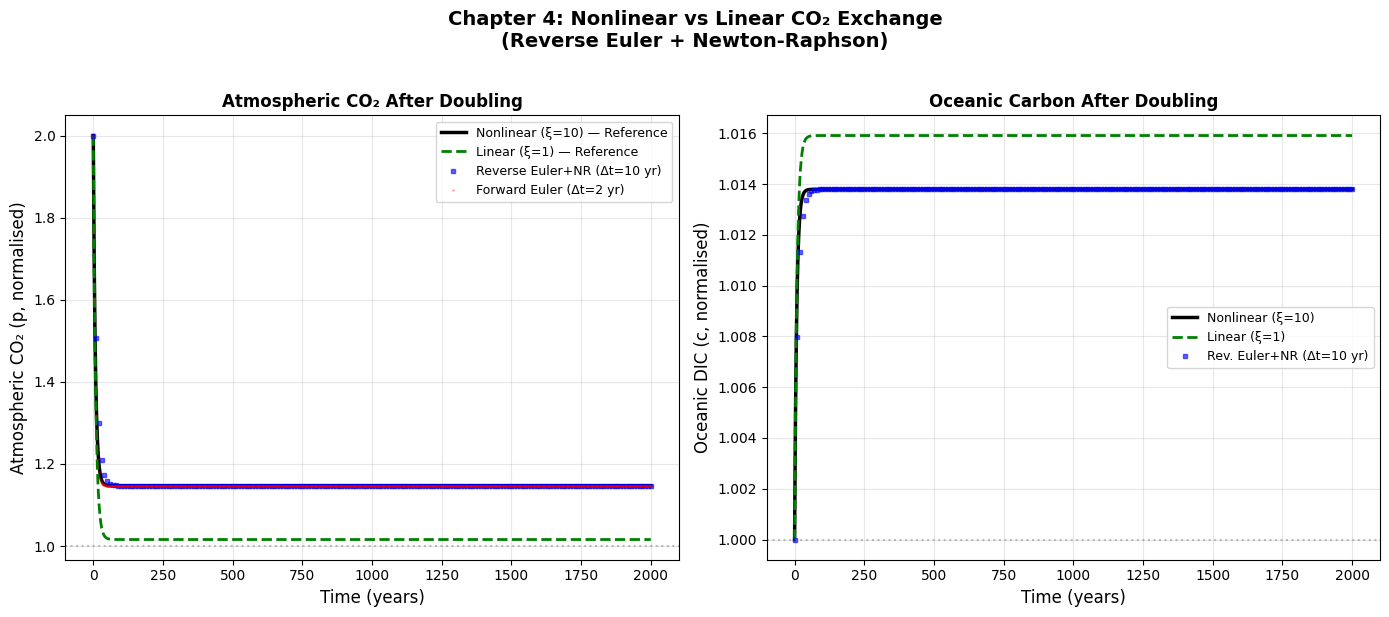


Final equilibrium atmospheric CO₂:
  Nonlinear (ξ=10): p = 1.1469  (+14.7% above preindustrial)
  Linear   (ξ=1):  p = 1.0159  (+1.6% above preindustrial)

Airborne fraction of perturbation:
  Nonlinear: 14.7%
  Linear:    1.6%


In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left panel: Atmospheric CO2
ax = axes[0]
ax.plot(t_ref, y_nl_ref[0], 'k-', linewidth=2.5,
        label=f'Nonlinear (ξ={xi:.0f}) — Reference')
ax.plot(t_ref, y_lin_ref[0], 'g--', linewidth=2,
        label='Linear (ξ=1) — Reference')
ax.plot(t_rev, y_rev[:, 0], 'bs', markersize=3, alpha=0.6,
        label=f'Reverse Euler+NR (Δt={dt:.0f} yr)')
ax.plot(t_fwd, y_fwd[:, 0], 'r+', markersize=2, alpha=0.4,
        label=f'Forward Euler (Δt={dt_fwd:.0f} yr)')
ax.axhline(y=1, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Time (years)', fontsize=12)
ax.set_ylabel('Atmospheric CO₂ (p, normalised)', fontsize=12)
ax.set_title('Atmospheric CO₂ After Doubling', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Right panel: Oceanic DIC
ax = axes[1]
ax.plot(t_ref, y_nl_ref[1], 'k-', linewidth=2.5,
        label=f'Nonlinear (ξ={xi:.0f})')
ax.plot(t_ref, y_lin_ref[1], 'g--', linewidth=2,
        label='Linear (ξ=1)')
ax.plot(t_rev, y_rev[:, 1], 'bs', markersize=3, alpha=0.6,
        label=f'Rev. Euler+NR (Δt={dt:.0f} yr)')
ax.axhline(y=1, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Time (years)', fontsize=12)
ax.set_ylabel('Oceanic DIC (c, normalised)', fontsize=12)
ax.set_title('Oceanic Carbon After Doubling', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

fig.suptitle('Chapter 4: Nonlinear vs Linear CO₂ Exchange\n'
             '(Reverse Euler + Newton-Raphson)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print final equilibrium values
p_eq_nl = y_nl_ref[0, -1]
p_eq_lin = y_lin_ref[0, -1]
print(f"\nFinal equilibrium atmospheric CO₂:")
print(f"  Nonlinear (ξ={xi:.0f}): p = {p_eq_nl:.4f}  ({(p_eq_nl-1)*100:+.1f}% above preindustrial)")
print(f"  Linear   (ξ=1):  p = {p_eq_lin:.4f}  ({(p_eq_lin-1)*100:+.1f}% above preindustrial)")
print(f"\nAirborne fraction of perturbation:")
print(f"  Nonlinear: {(p_eq_nl - 1)/(p0_pert - 1):.1%}")
print(f"  Linear:    {(p_eq_lin - 1)/(p0_pert - 1):.1%}")

**The key result:** With the Revelle factor, a much larger fraction of the
CO₂ perturbation remains in the atmosphere at equilibrium. The ocean's
buffer chemistry limits its ability to absorb the excess.

The linear model (ξ = 1) predicts the atmosphere returns almost to its
preindustrial level — the ocean swallows nearly everything. The nonlinear
model shows that a significant fraction (~14%) stays airborne permanently
(until other processes like silicate weathering act on much longer timescales).

---

## 4.7 Newton-Raphson Convergence Diagnostics

Walker emphasises monitoring the Newton iterations. Typically only 2–4
iterations are needed per time step, demonstrating the efficiency of the
method.

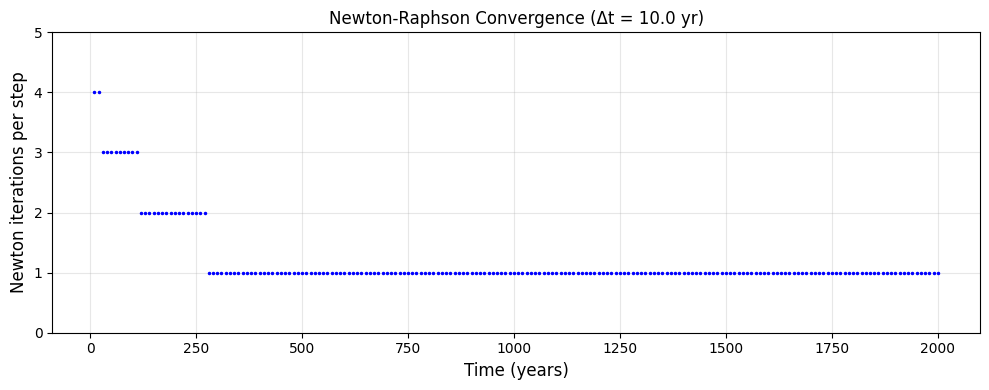

Newton iterations — min: 1, max: 4, mean: 1.2
Most steps at the beginning when the system changes rapidly.


In [30]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(t_rev[1:], niters, 'b.', markersize=3)
ax.set_xlabel('Time (years)', fontsize=12)
ax.set_ylabel('Newton iterations per step', fontsize=12)
ax.set_title(f'Newton-Raphson Convergence (Δt = {dt} yr)', fontsize=12)
ax.set_ylim(0, max(niters) + 1)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Newton iterations — min: {min(niters)}, max: {max(niters)}, "
      f"mean: {np.mean(niters):.1f}")
print(f"Most steps at the beginning when the system changes rapidly.")

---

## 4.8 Experiment 2: Stability Comparison

Just as in Chapters 2 and 3, the reverse Euler remains stable at large
time steps where the forward Euler fails. For nonlinear systems, the
forward Euler can fail even more dramatically.

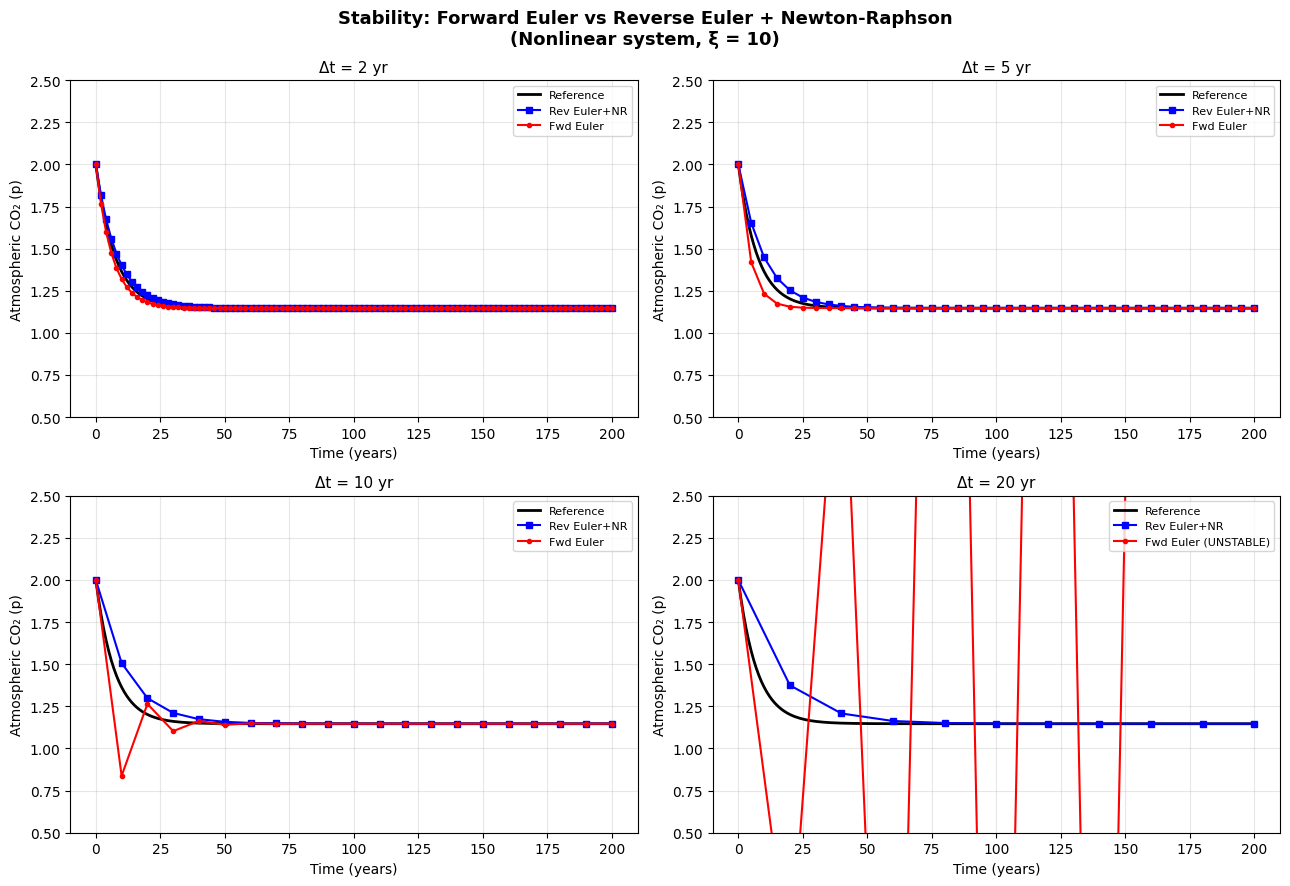

In [31]:
test_dts = [2, 5, 10, 20]

fig, axes = plt.subplots(2, 2, figsize=(13, 9))
fig.suptitle('Stability: Forward Euler vs Reverse Euler + Newton-Raphson\n'
             f'(Nonlinear system, ξ = {xi:.0f})',
             fontsize=13, fontweight='bold')

for ax, dt_test in zip(axes.flat, test_dts):
    # Reference
    ax.plot(t_ref[t_ref <= 200], y_nl_ref[0][t_ref <= 200], 'k-',
            linewidth=2, label='Reference')
    
    # Reverse Euler + Newton
    try:
        t_r, y_r, _ = reverse_euler_newton(y0, dt_test, 200)
        ax.plot(t_r, y_r[:, 0], 'bs-', markersize=4,
                label=f'Rev Euler+NR')
    except Exception:
        ax.text(100, 1.5, 'Rev Euler: FAILED', fontsize=10, color='blue')
    
    # Forward Euler
    try:
        t_f, y_f = forward_euler_nl(y0, dt_test, 200)
        # Check if it blew up
        if np.any(np.abs(y_f[:, 0]) > 100) or np.any(np.isnan(y_f)):
            # Clip for display
            y_clip = np.clip(y_f[:, 0], -5, 10)
            ax.plot(t_f, y_clip, 'ro-', markersize=3,
                    label='Fwd Euler (UNSTABLE)')
        else:
            ax.plot(t_f, y_f[:, 0], 'ro-', markersize=3,
                    label='Fwd Euler')
    except Exception:
        ax.text(100, 1.8, 'Fwd Euler: FAILED', fontsize=10, color='red')
    
    ax.set_title(f'Δt = {dt_test} yr', fontsize=11)
    ax.set_xlabel('Time (years)')
    ax.set_ylabel('Atmospheric CO₂ (p)')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0.5, 2.5)

plt.tight_layout()
plt.show()

---

## 4.9 Experiment 3: The Effect of the Revelle Factor

How does the Revelle factor control the long-term fate of atmospheric CO₂?
We scan across different values of ξ to show its profound influence.

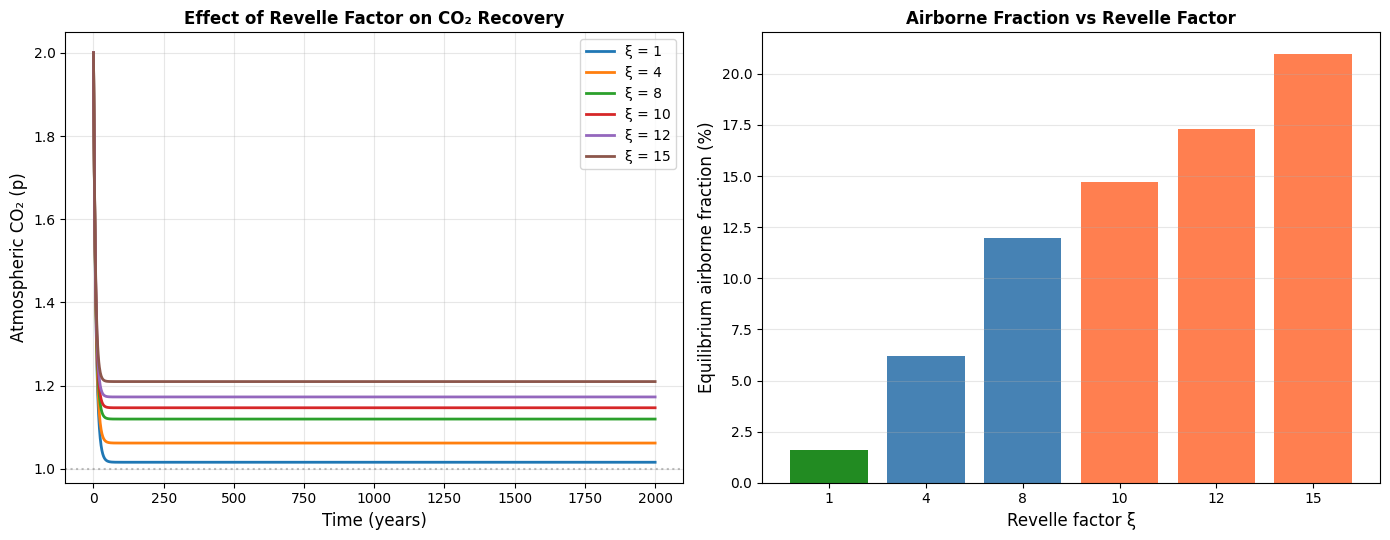

Equilibrium airborne fractions:
  ξ =  1: 1.6%
  ξ =  4: 6.2%
  ξ =  8: 12.0%
  ξ = 10: 14.7%
  ξ = 12: 17.3%
  ξ = 15: 21.0%


In [32]:
xi_test = [1, 4, 8, 10, 12, 15]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5.5))

airborne_fractions = []

for xi_val in xi_test:
    # Temporarily override xi
    def make_ode(xi_v):
        def ode(t, y):
            p, c = y
            flux = (c**xi_v - p) / tau
            return [flux, -mu * flux]
        return ode
    
    sol = solve_ivp(make_ode(xi_val), [0, t_end], y0,
                    dense_output=True, rtol=1e-12, atol=1e-14,
                    method='Radau')
    y_sol = sol.sol(t_ref)
    
    ax1.plot(t_ref, y_sol[0], linewidth=2, label=f'ξ = {xi_val}')
    
    p_final = y_sol[0, -1]
    af = (p_final - 1) / (p0_pert - 1)
    airborne_fractions.append(af)

ax1.axhline(y=1, color='gray', linestyle=':', alpha=0.5)
ax1.set_xlabel('Time (years)', fontsize=12)
ax1.set_ylabel('Atmospheric CO₂ (p)', fontsize=12)
ax1.set_title('Effect of Revelle Factor on CO₂ Recovery',
              fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

ax2.bar(range(len(xi_test)), [af * 100 for af in airborne_fractions],
        tick_label=[str(x) for x in xi_test],
        color=['forestgreen' if x <= 1 else 'steelblue' if x < 10
               else 'coral' for x in xi_test])
ax2.set_xlabel('Revelle factor ξ', fontsize=12)
ax2.set_ylabel('Equilibrium airborne fraction (%)', fontsize=12)
ax2.set_title('Airborne Fraction vs Revelle Factor',
              fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Equilibrium airborne fractions:")
for xi_val, af in zip(xi_test, airborne_fractions):
    print(f"  ξ = {xi_val:2d}: {af:.1%}")

This is one of the most important results in the carbon cycle: the Revelle
factor determines how much of our CO₂ emissions stay in the atmosphere.

For the real ocean ($\xi \approx 10$), roughly 14% of a CO₂ perturbation
remains airborne permanently (on timescales of centuries). Only on much
longer timescales (~100,000 years) does silicate weathering draw down the
remaining excess.

Without the Revelle effect ($\xi = 1$), almost all CO₂ would be absorbed
by the ocean and the problem of anthropogenic climate change would be
vastly diminished.

---

## 4.10 Finding Equilibria of Nonlinear Systems

Walker also shows how Newton-Raphson can find steady states directly.
At equilibrium, $\mathbf{f}(\mathbf{y}) = \mathbf{0}$ plus the conservation
constraint. For our system:

1. $c^\xi = p$ (equal pCO₂ in atmosphere and ocean)
2. $p \cdot M_a + c \cdot M_o = \text{total carbon}$

In [33]:
def find_equilibrium(p0_init, c0_init, M_a, M_o, xi, total_C):
    """Find equilibrium using Newton-Raphson.
    
    Equations:
      g1 = c^xi - p = 0        (equal pCO2)
      g2 = p*M_a + c*M_o - C = 0  (conservation)
    """
    def g(x):
        p, c = x
        return np.array([c**xi - p,
                        p * M_a + c * M_o - total_C])
    
    def Jg(x):
        p, c = x
        return np.array([[-1,      xi * c**(xi-1)],
                        [M_a,     M_o           ]])
    
    x = np.array([p0_init, c0_init])
    for k in range(50):
        gx = g(x)
        if np.max(np.abs(gx)) < 1e-12:
            return x, k + 1
        dx = np.linalg.solve(Jg(x), -gx)
        x = x + dx
    return x, 50

# Find equilibrium for the doubling experiment
total_C_pert = p0_pert * M_a + c0_pert * M_o  # 1200 + 37100 = 38300
equil, n_iters = find_equilibrium(1.5, 1.0, M_a, M_o, xi, total_C_pert)

print(f"Equilibrium found in {n_iters} Newton iterations:")
print(f"  p_eq = {equil[0]:.6f} (atmospheric CO₂)")
print(f"  c_eq = {equil[1]:.6f} (oceanic DIC)")
print(f"  Verification: c^ξ = {equil[1]**xi:.6f} (should ≈ p = {equil[0]:.6f})")
print(f"  Conservation: {equil[0]*M_a + equil[1]*M_o:.1f} GtC (should be {total_C_pert:.0f})")
print(f"\n  Airborne fraction: {(equil[0]-1)/(p0_pert-1):.1%}")

Equilibrium found in 4 Newton iterations:
  p_eq = 1.146863 (atmospheric CO₂)
  c_eq = 1.013797 (oceanic DIC)
  Verification: c^ξ = 1.146863 (should ≈ p = 1.146863)
  Conservation: 38300.0 GtC (should be 38300)

  Airborne fraction: 14.7%


---

## 4.11 Experiment 4: Comparing Forward Euler, Reverse Euler, and Linearised Reverse Euler

Walker also discusses a **semi-implicit** approach: linearise the nonlinear
terms using the *previous* time step's values (i.e., take only one Newton
iteration instead of iterating to convergence). This is simpler but less
accurate. Let's compare all three approaches.

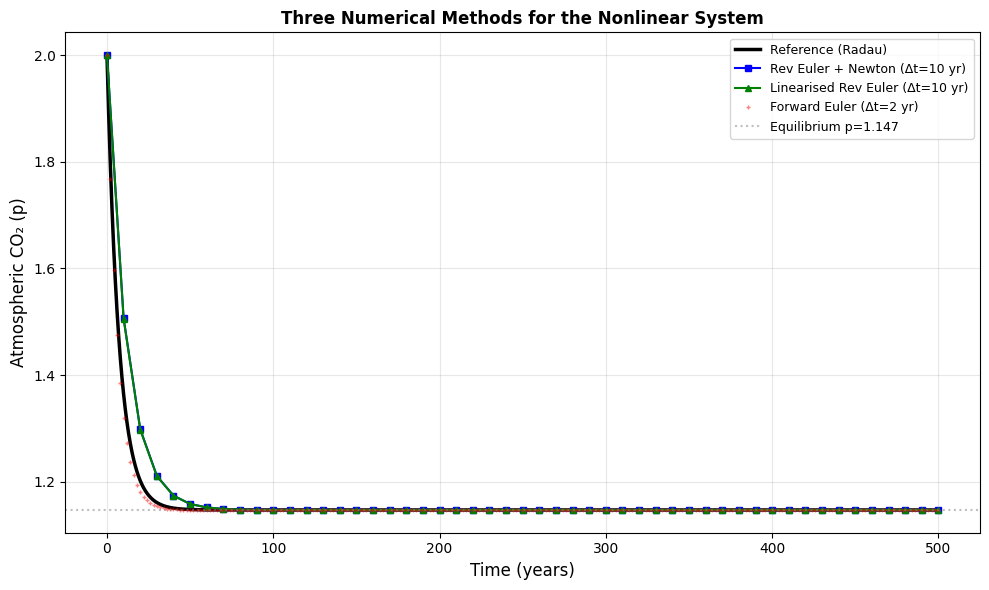

In [34]:
def linearised_reverse_euler(y0, dt, t_end):
    """Semi-implicit: linearise about y^n, solve one linear system.
    
    (I - dt*Jf(y^n)) * (y^{n+1} - y^n) = dt * f(y^n)
    This is equivalent to one Newton iteration with y^n as initial guess.
    """
    t = np.arange(0, t_end + dt, dt)
    y = np.zeros((len(t), len(y0)))
    y[0] = y0
    I = np.eye(len(y0))
    
    for n in range(len(t) - 1):
        fn = np.array(nonlinear_co2(t[n], y[n]))
        Jf = jacobian_f(y[n])
        LHS = I - dt * Jf
        RHS = dt * fn
        delta = np.linalg.solve(LHS, RHS)
        y[n+1] = y[n] + delta
    return t, y

dt_comp = 10.0
t_comp_end = 500.0

t_r, y_r, _ = reverse_euler_newton(y0, dt_comp, t_comp_end)
t_l, y_l = linearised_reverse_euler(y0, dt_comp, t_comp_end)
t_f, y_f = forward_euler_nl(y0, 2.0, t_comp_end)  # small step for stability

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_ref[t_ref <= t_comp_end], y_nl_ref[0][t_ref <= t_comp_end],
        'k-', linewidth=2.5, label='Reference (Radau)')
ax.plot(t_r, y_r[:, 0], 'bs-', markersize=5,
        label=f'Rev Euler + Newton (Δt={dt_comp:.0f} yr)')
ax.plot(t_l, y_l[:, 0], 'g^-', markersize=5,
        label=f'Linearised Rev Euler (Δt={dt_comp:.0f} yr)')
ax.plot(t_f, y_f[:, 0], 'r+', markersize=3, alpha=0.5,
        label='Forward Euler (Δt=2 yr)')

ax.axhline(y=equil[0], color='gray', linestyle=':', alpha=0.5,
           label=f'Equilibrium p={equil[0]:.3f}')
ax.set_xlabel('Time (years)', fontsize=12)
ax.set_ylabel('Atmospheric CO₂ (p)', fontsize=12)
ax.set_title('Three Numerical Methods for the Nonlinear System',
             fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

The full Newton iteration gives the best results at large time steps,
while the linearised version introduces some additional error but remains
stable. The forward Euler requires much smaller time steps.

---

## 4.12 Exercises

**Exercise 4.1:** Derive the formula for the equilibrium airborne fraction
analytically. Given $c^\xi = p$ and $p \cdot M_a + c \cdot M_o = C_{\text{total}}$,
show that for small perturbations $\delta p$ around $p = c = 1$, the airborne
fraction is approximately $\xi / (\xi + M_o/M_a)$.

**Exercise 4.2:** Add a third reservoir (land biosphere) to the nonlinear
model. The biosphere exchanges CO₂ with the atmosphere at 120 GtC/yr, with
a biospheric carbon pool of 2000 GtC. How does this change the transient
response and the equilibrium airborne fraction?

**Exercise 4.3:** The Revelle factor increases as more CO₂ is added to the
ocean (positive feedback). Modify the model so that $\xi = \xi_0 + \alpha(c - 1)$
where $\alpha > 0$ represents this effect. How does the airborne fraction change?

**Exercise 4.4:** Implement a time-varying emission scenario: $S(t) = S_0 e^{\alpha t}$
for $t < t_{\text{stop}}$, then $S = 0$. Use the reverse Euler + Newton method to
simulate the atmospheric CO₂ trajectory. How long after emissions cease does
the atmosphere take to reach 90% of its final equilibrium?

**Exercise 4.5:** Walker notes that the Newton-Raphson method can fail if the
initial guess is too far from the solution. Experiment with very large time
steps or very large perturbations ($p_0 = 10$) and observe convergence behaviour.
What happens, and how might you improve robustness?

---

## 4.13 Bonus: Exercise 4.4 Worked Example — Emissions Pulse

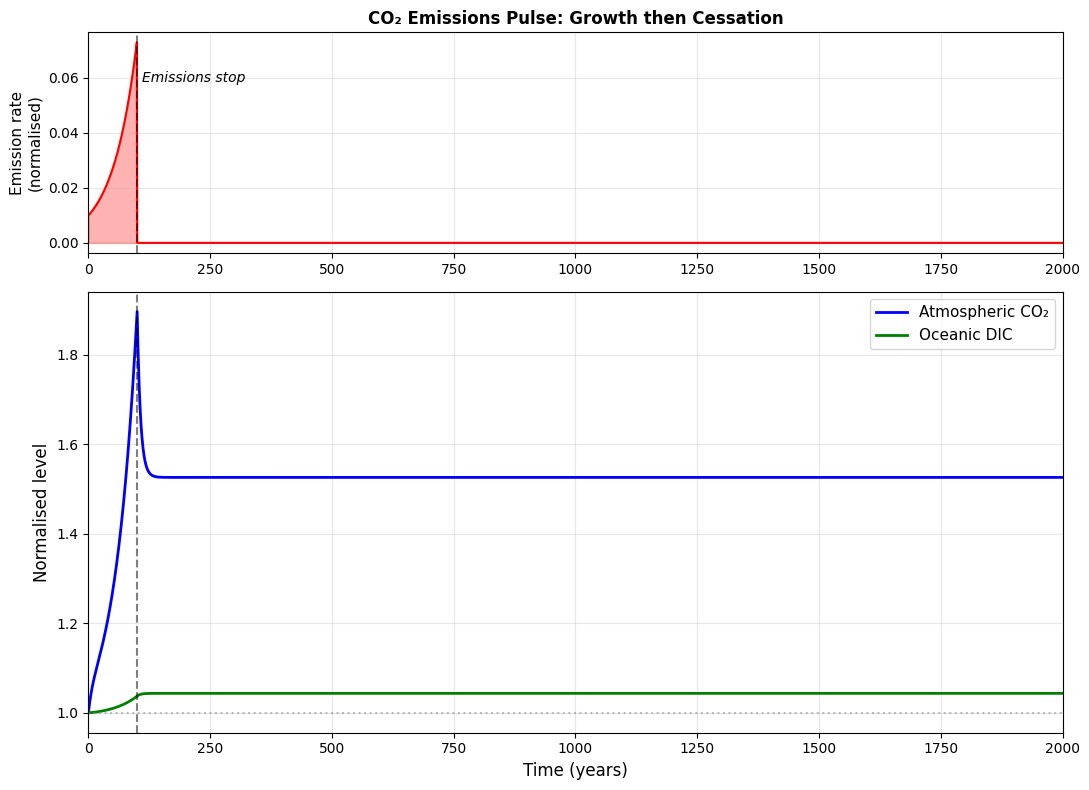

Peak atmospheric CO₂: p = 1.896 (531 ppm if preindustrial=280 ppm)
Final atmospheric CO₂: p = 1.526 (427 ppm)
Long-term airborne fraction: 58.7%


In [35]:
# Exercise 4.4: Fossil fuel pulse followed by cessation

S0 = 0.01         # initial emission rate (normalised)
alpha_em = 0.02    # 2% growth/yr
t_stop = 100.0     # emissions stop at t=100 yr
t_end_em = 2000.0

def emission_source(t):
    """Exponentially growing emissions, then zero."""
    if t < t_stop:
        return S0 * np.exp(alpha_em * t)
    else:
        return 0.0

def nonlinear_co2_emissions(t, y):
    """Nonlinear CO2 system with emissions source."""
    p, c = y
    flux = (c**xi - p) / tau
    S = emission_source(t)
    dpdt = flux + S
    dcdt = -mu * flux
    return [dpdt, dcdt]

# Solve with SciPy (Radau for stiffness)
sol_em = solve_ivp(nonlinear_co2_emissions, [0, t_end_em], [1.0, 1.0],
                   dense_output=True, rtol=1e-10, atol=1e-12,
                   method='Radau', max_step=1.0)

t_em = np.linspace(0, t_end_em, 3000)
y_em = sol_em.sol(t_em)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 8), height_ratios=[1, 2])

# Top: emissions profile
emissions = [emission_source(t) for t in t_em]
ax1.fill_between(t_em, emissions, alpha=0.3, color='red')
ax1.plot(t_em, emissions, 'r-', linewidth=1.5)
ax1.set_ylabel('Emission rate\n(normalised)', fontsize=11)
ax1.set_title('CO₂ Emissions Pulse: Growth then Cessation',
              fontsize=12, fontweight='bold')
ax1.axvline(x=t_stop, color='k', linestyle='--', alpha=0.5)
ax1.text(t_stop + 10, max(emissions) * 0.8, 'Emissions stop',
         fontsize=10, style='italic')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, t_end_em)

# Bottom: atmospheric CO2 response
ax2.plot(t_em, y_em[0], 'b-', linewidth=2, label='Atmospheric CO₂')
ax2.plot(t_em, y_em[1], 'g-', linewidth=2, label='Oceanic DIC')
ax2.axhline(y=1, color='gray', linestyle=':', alpha=0.5)
ax2.axvline(x=t_stop, color='k', linestyle='--', alpha=0.5)
ax2.set_xlabel('Time (years)', fontsize=12)
ax2.set_ylabel('Normalised level', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, t_end_em)

plt.tight_layout()
plt.show()

p_peak = y_em[0].max()
p_final = y_em[0, -1]
print(f"Peak atmospheric CO₂: p = {p_peak:.3f} ({p_peak*280:.0f} ppm if preindustrial=280 ppm)")
print(f"Final atmospheric CO₂: p = {p_final:.3f} ({p_final*280:.0f} ppm)")
print(f"Long-term airborne fraction: {(p_final - 1)/(p_peak - 1):.1%}")

This is a powerful result: even after emissions completely cease, atmospheric
CO₂ remains elevated for centuries because the ocean's buffer chemistry
(the Revelle factor) prevents it from absorbing the excess quickly.

The fast initial decline is the atmosphere equilibrating with the surface
ocean. The slow tail is the deep ocean gradually absorbing the remainder.
And a significant fraction persists essentially forever (on human timescales)
— this is the "long tail" of CO₂ that makes climate change so persistent.

---

## References

- Walker, J.C.G. (1991). *Numerical Adventures with Geochemical Cycles*.
  Oxford University Press. Chapter 4: "How to Solve a Nonlinear System."
- Broecker, W.S. and Peng, T.-H. (1982). *Tracers in the Sea*.
  Eldigio Press, Palisades, New York.
- Revelle, R. and Suess, H.E. (1957). Carbon dioxide exchange between
  atmosphere and ocean and the question of an increase of atmospheric CO₂
  during the past decades. *Tellus*, 9, 18–27.
- Egleston, E.S., Sabine, C.L., and Morel, F.M.M. (2010). Revelle revisited:
  Buffer factors that quantify the response of ocean chemistry to changes
  in DIC and alkalinity. *Global Biogeochemical Cycles*, 24, GB1002.